# Import necessary libraries

In [113]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.base import clone
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
import time
import copy
import lightgbm as lgb


# Load and preprocess data set

In [2]:
MIMIC_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_dynamic.parquet"
MIMIC_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/mimic_static.parquet"
EICU_DATA_PATH_DYNAMIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_dynamic.parquet"
EICU_DATA_PATH_STATIC = "/userdata/lucabri/icu-experiments/data/processed/eicu_static.parquet"

## Preprocessing

In [79]:
def preprocess(DYNAMIC_PATH, STATIC_PATH):
    # komisch: Malte macht log von bicar aber nicht von bili_dir --> würde ich swappen
    columns_to_transform = ["alp", 'alt', 'ast', 'bili', 'bili_dir', 'bnd', 'bun', 'ck', 'ckmb',
                            'crea', 'crp', 'fgn', 'fio2', 'glu', 'hgb', 'inr_pt', 'lact', 'lymph',
                             'methb', 'neut', 'o2sat', 'phos', 'plt', 'pco2', 'ph', 'po2', 'ptt', 
                             'urine', 'tnt', 'wbc']

    df_dynamic = pd.read_parquet(DYNAMIC_PATH)
    df_dynamic[columns_to_transform] = df_dynamic[columns_to_transform].apply(np.log)
    df_static = pd.read_parquet(STATIC_PATH)

    if "sex" in df_static.columns:
        df_static['sex'] = df_static['sex'].apply(lambda x: 0 if x == 'Male' else 1)

    # Rename columns to have a unified column name for IDs and time across datasets
    column_renames = {
        'icustay_id': 'stay_id', 
        'patientunitstayid': 'stay_id',
        'charttime': 'time',
        'labresultoffset': 'time'
    }
    df_dynamic.rename(columns=column_renames, inplace=True)
    df_static.rename(columns=column_renames, inplace=True)

    # Group and calculate mean for day 1 and day 3
    df_dynday1 = df_dynamic[lambda x: x["time"].dt.days == 0].groupby("stay_id").mean()
    df_dynday3 = df_dynamic[lambda x: x['time'].dt.days == 2].groupby("stay_id").mean()
    
    # Merge with static features and fill NaN values
    df_day1 = pd.merge(df_dynday1, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')
    df_day3 = pd.merge(df_dynday3, df_static, on="stay_id", how="outer", validate="m:1").set_index('stay_id')

    # drop the 'time' column since it's not needed
    # drop crp and methb since only two values recorded
    df_day1.drop(columns=["time"], inplace=True)
    df_day3.drop(columns=["time"], inplace=True)

    # Detect -inf values in DataFrame day1
    inf_mask = df_day1.isin([-np.inf])
    # Add an indicator column based on whether -inf was replaced
    df_day1['inf_replaced'] = inf_mask.any(axis=1).astype(int)
    # Replace -inf with NaN
    df_day1.replace(-np.inf, np.nan, inplace=True)
    
    # Perform an inner join on the 'stay_id' column
    df = pd.merge(df_day3['hr'], df_day1, on='stay_id', how='inner')
    df.rename(columns={'hr_x': 'hr3',
                       'hr_y': 'hr1'}, inplace=True)
    
    df.dropna(subset=["hr3", "hr1"], inplace=True)

    # Create a new DataFrame to hold the indicators
    indicators = df.isna().astype(int)

    # Rename the indicator columns to distinguish them
    indicators.columns = [str(col) + '_was_nan' for col in df.columns]

    # Replace NaN values with the mean of the column
    for column in df.columns:
        df[column].fillna(df[column].mean(), inplace=True)

    # Concatenate the original DataFrame with the indicator DataFrame
    df = pd.concat([df, indicators], axis=1)

    return df

In [ ]:
df_mimic = preprocess(MIMIC_DATA_PATH_DYNAMIC, MIMIC_DATA_PATH_STATIC)
df_eicu = preprocess(EICU_DATA_PATH_DYNAMIC, EICU_DATA_PATH_STATIC)

## Automated EDA

In [ ]:

dataframes = {
    'eicu': df_eicu,
    'mimic': df_mimic
}

for name, df in dataframes.items():

    cols_to_drop = [col for col in df.columns if '_was_nan' in col]
    df = df.drop(columns=cols_to_drop)

    # Analyze the dataset
    report = sv.analyze(df, target_feat='hr3')

    # Display the report as HTML
    report.show_html(f'{name}_Report.html')

# Random Forest Prediction

In [114]:
def plot_mse_vs_tuning_points(n_test_range, mse_values_rf, mse_values_lgbm):
    plt.figure(figsize=(10, 6))
    plt.plot(n_test_range, mse_values_rf, '-o', label='Random Forest', linewidth=2, color='blue')
    plt.plot(n_test_range, mse_values_lgbm, '-o', label='LightGBM', linewidth=2, color='green')
    plt.title("MSE vs Number of tuning Data Points")
    plt.xlabel("Number of tuning Points")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)
    plt.show()

In [116]:
def main(df1, df2, param_grid):
    start_time = time.time()

    X_train = df1.drop('hr3', axis=1)
    y_train = df1['hr3']
    X_test = df2.drop('hr3', axis=1)
    y_test = df2['hr3']
    
    rf = RandomForestRegressor(random_state=42)
    lgbm = lgb.LGBMRegressor(random_state=42)
    
    rf.fit(X_train,y_train)
    lgbm.fit(X_train, y_train)

    part1_end = time.time()
    print(f"Training took: {part1_end - start_time} seconds \n")

    # Random Forest predictions
    y_pred_insample_rf = rf.predict(X_train)
    # LightGBM predictions
    y_pred_insample_lgbm = lgbm.predict(X_train)
    
    part2_end = time.time()
    print(f"Predicting took: {part2_end - part1_end} seconds \n")

    # In sample MSE for Random Forest
    in_sample_mse_rf = mean_squared_error(y_train, y_pred_insample_rf)
    print(f"In sample RF MSE: {in_sample_mse_rf}")
    # In sample MSE for LightGBM
    in_sample_mse_lgbm = mean_squared_error(y_train, y_pred_insample_lgbm)
    print(f"In sample LGBM MSE: {in_sample_mse_lgbm}")
    # Do nothing prediction
    dummy_mse = mean_squared_error(y_test, np.full_like(y_test, y_train.mean()))
    print(f'Do nothing-mse is {dummy_mse} \n')

    """"""""""
    Do only if access to Euler otherwise pc in brrrr state
    #grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    #grid_search.fit(X_train, y_train)
    #best_training_model = grid_search.best_estimator_
    #print("Finished grid search and selected best estimator \n")
    """""""""""

    mse_values_rf = []
    mse_values_lgbm = []
    n_test_range = [0, 25, 50, 100, 200, 400, 800, 1600]

    # When n_test is 0, use the entire X_test and y_test for evaluation without further splitting
    X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = [], X_test, [], y_test
    fine_time = time.time()
    for n_test in n_test_range:
        print(f"Currently in n_test= {n_test}")

        # Random Forest fine-tuning and evaluation
        copied_model_rf = copy.deepcopy(rf)
        # LightGBM fine-tuning and evaluation
        copied_model_lgbm = copy.deepcopy(lgbm)
        
        if n_test > 0:
            X_fine_tune, X_evaluate, y_fine_tune, y_evaluate = train_test_split(X_test, y_test, test_size=n_test/len(X_test), random_state=42)
            copied_model_lgbm.fit(X_fine_tune, y_fine_tune)
            copied_model_rf.fit(X_fine_tune, y_fine_tune)

        y_pred_rf = copied_model_rf.predict(X_evaluate)
        y_pred_lgbm = copied_model_lgbm.predict(X_evaluate)
        
        mse_values_rf.append(mean_squared_error(y_evaluate, y_pred_rf))
        mse_values_lgbm.append(mean_squared_error(y_evaluate, y_pred_lgbm))

        fine_test_time = time.time()
        print(f"Fine-tuning with {n_test} data points took: {fine_test_time - fine_time} seconds")
        print(f"RF MSE: {mse_values_rf[-1]} | LGBM MSE: {mse_values_lgbm[-1]} \n")
        fine_time = fine_test_time

    plot_mse_vs_tuning_points(n_test_range, mse_values_rf, mse_values_lgbm)

In [84]:
# Define the parameter grid (adjust as needed)
param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None, 10, 20, 30],
    'max_leaf_nodes': [None, 10, 20],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10]
}

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.137386 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 12487
[LightGBM] [Info] Number of data points in the train set: 74648, number of used features: 102
[LightGBM] [Info] Start training from score 84.928584
Training took: 435.9652988910675 seconds 

Predicting took: 3.768826484680176 seconds 

In sample RF MSE: 20.89946197254035
In sample LGBM MSE: 133.0193377917114
Do nothing-mse is 548.8081578499456 

Currently in n_test= 0
Fine-tuning for 0 took: 1.816957712173462 seconds
RF MSE: 219.61911657814446 | LGBM MSE: 230.07938068977137 

Currently in n_test= 25
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12341
[LightGBM] [Info] Number of data poin

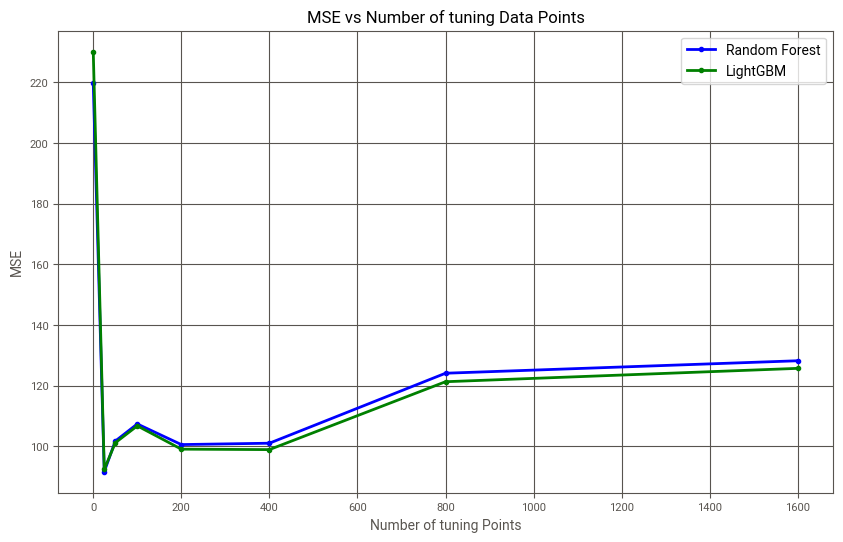

In [117]:
main(df_eicu, df_mimic, param_grid)